**Importação de Bibliotecas**

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import plotly.express as px
import plotly.graph_objs as go

**Carregamento e Preparação dos Dados**

In [69]:
df = pd.read_csv('ecommerce_sales_analysis.csv')
df['total_sales'] = df.iloc[:, 6:18].sum(axis=1)

**Previsão de Vendas com Prophet (Adicionando Feriados)**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgrrr_pf/inocza4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgrrr_pf/gihwb3r9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57441', 'data', 'file=/tmp/tmpqgrrr_pf/inocza4x.json', 'init=/tmp/tmpqgrrr_pf/gihwb3r9.json', 'output', 'file=/tmp/tmpqgrrr_pf/prophet_model2kxrt17w/prophet_model-20240730211417.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:14:17 - cmdstanpy - INFO - Chain [1] start processing
IN

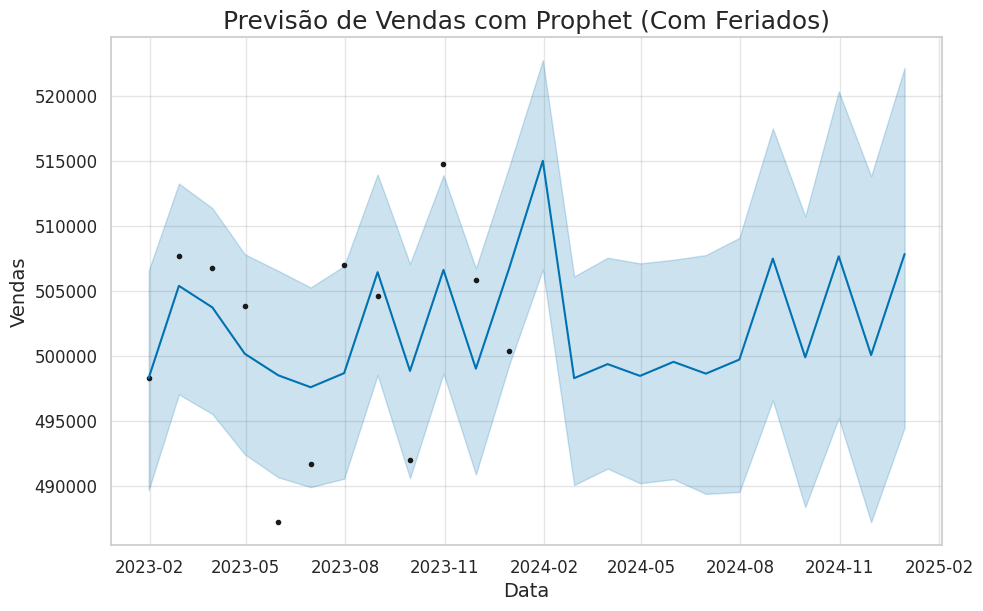

Prophet with Holidays RMSE: 6231.363260777186
Prophet with Holidays MAE: 5396.058328618984


In [70]:
def forecast_sales_prophet_with_holidays(data, periods=12):
    sales = data.iloc[:, 6:18].sum(axis=0)
    sales.index = pd.date_range(start='2023-01-01', periods=len(sales), freq='M')

    df_sales = sales.reset_index()
    df_sales.columns = ['ds', 'y']

    holidays = pd.DataFrame({
        'holiday': 'holiday',
        'ds': pd.to_datetime(['2023-01-01', '2023-12-25']),
        'lower_window': 0,
        'upper_window': 1,
    })

    model = Prophet(holidays=holidays)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(df_sales)

    future = model.make_future_dataframe(periods=periods, freq='M')
    forecast = model.predict(future)

    fig = model.plot(forecast)
    plt.title('Previsão de Vendas com Prophet (Com Feriados)')
    plt.xlabel('Data')
    plt.ylabel('Vendas')
    plt.show()

    y_true = df_sales['y']
    y_pred = model.predict(df_sales[['ds']])['yhat']
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f'Prophet with Holidays RMSE: {rmse}')
    print(f'Prophet with Holidays MAE: {mae}')

forecast_sales_prophet_with_holidays(df)


**Análise de Desempenho de Produtos**

In [71]:
def analyze_product_performance(data):
    category_sales = data.groupby('category')['total_sales'].sum().reset_index()
    top_products = data.nlargest(10, 'total_sales')
    bottom_products = data.nsmallest(10, 'total_sales')

    fig1 = px.bar(category_sales, x='category', y='total_sales', title='Total de Vendas por Categoria')
    fig2 = px.bar(top_products, x='product_name', y='total_sales', title='Top 10 Produtos Mais Vendidos')
    fig3 = px.bar(bottom_products, x='product_name', y='total_sales', title='Top 10 Produtos Menos Vendidos')

    fig1.show()
    fig2.show()
    fig3.show()

analyze_product_performance(df)

**Segmentação de Mercado**

In [72]:
def market_segmentation(data):
    features = data[['price', 'review_score', 'review_count', 'total_sales']]
    kmeans = KMeans(n_clusters=3)
    data['cluster'] = kmeans.fit_predict(features)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features)
    pc_df = pd.DataFrame(data=principal_components, columns=['pc1', 'pc2'])
    pc_df['cluster'] = data['cluster']

    fig = px.scatter(pc_df, x='pc1', y='pc2', color='cluster', title='Segmentação de Mercado com K-Means')
    fig.show()

market_segmentation(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



**Análise de Sentimento das Avaliações**

In [73]:
def sentiment_analysis(data):
    data['sentiment'] = np.where(data['review_score'] >= 4, 'positive', 'negative')
    sentiment_count = data['sentiment'].value_counts().reset_index()
    sentiment_count.columns = ['sentiment', 'count']

    fig = px.pie(sentiment_count, values='count', names='sentiment', title='Análise de Sentimento das Avaliações')
    fig.show()

sentiment_analysis(df)

**Otimização de Preços**

In [74]:
def optimize_prices(data):
    features = data[['price', 'review_score', 'review_count']]
    target = data['total_sales']

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    importance = model.feature_importances_
    feature_importance = pd.DataFrame({'feature': features.columns, 'importance': importance}).sort_values(by='importance', ascending=False)

    fig = px.bar(feature_importance, x='feature', y='importance', title='Importância das Características na Otimização de Preços')
    fig.show()

    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

optimize_prices(df)

RMSE: 1041.624288057119
MAE: 824.1827499999999
